In [15]:
#source: https://github.com/taspinar/twitterscraper
#query: twitterscraper '#savetheturtles' -l 1200 --lang=en -bd 2018-01-01 -o turtletweets4.json

import codecs, json
import pandas as pd
import nltk
import operator
import re,string
from patsy import dmatrices
%pylab inline
from nltk.corpus import stopwords
from itertools import chain
from collections import Counter
import random
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [16]:
with codecs.open('turtletweets4.json', 'r', 'utf-8') as f:
    tweets = json.load(f, encoding='utf-8')
    
list_tweets = [list(elem.values()) for elem in tweets]
list_columns = list(tweets[0].keys())
df = pd.DataFrame(list_tweets, columns=list_columns)

In [17]:
df.shape

(1488, 10)

In [18]:
df.head()

,fullname,html,id,likes,replies,retweets,text,timestamp,url,user
0,Amy Weston,"<p class=""TweetTextSize js-tweet-text tweet-te...",954073160017698816,0,0,0,I'm so excited to volunteer at the turtle cons...,2018-01-18T19:29:01,/amywestonn17/status/954073160017698816,amywestonn17
1,Brian Griffin,"<p class=""TweetTextSize js-tweet-text tweet-te...",954069187034431488,0,0,0,Buy na guys! #SavetheTurtles https://twitter.c...,2018-01-18T19:13:14,/ken_fanfan/status/954069187034431488,ken_fanfan
2,Jacob Garcia,"<p class=""TweetTextSize js-tweet-text tweet-te...",954003992954200064,2,0,0,Respect to the folks risking life and limb put...,2018-01-18T14:54:11,/BigJakeRN/status/954003992954200064,BigJakeRN
3,Samuel Magpuyo,"<p class=""TweetTextSize js-tweet-text tweet-te...",953991252730560512,3,0,0,Or dont use straw when in fastfood. #SaveTheTu...,2018-01-18T14:03:33,/mrsimsim/status/953991252730560512,mrsimsim
4,Pola,"<p class=""TweetTextSize js-tweet-text tweet-te...",953972101676916737,2032,93,639,STRAW SET for PHP 150 only \n\n- Metal straw\n...,2018-01-18T12:47:27,/lebasyyy/status/953972101676916737,lebasyyy


## Preprocessing
1. converting to lowercase
2. stripping punctuation
3. stemming the words to find the root of the word (e.g. “running” and “runs” both get reduced to “run”)
4. removing little words like “the”, “and”, or “if”, which are known as stop words

In [19]:
#preprocess text column to lowercase, remove punctuation, and put all into one list using sum
text2 = df['text'].apply(lambda x:re.sub(r"[^a-zA-Z0-9\s]", "", x.lower())).sum()
des_words = nltk.word_tokenize(text2)
des_words = [word for word in des_words if word.isalpha()==True] #get rid of punctuation

In [20]:
#remove stopwords
stop = set(stopwords.words('english'))
filtered_stopwords = [word for word in des_words if word not in stop]

print(len(des_words))
print(len(filtered_stopwords))

26883
17499


In [21]:
filtered_pos = nltk.pos_tag(filtered_stopwords)
filtered_pos[:10]

[('im', 'NN'),
 ('excited', 'VBD'),
 ('volunteer', 'NN'),
 ('turtle', 'NN'),
 ('conservation', 'NN'),
 ('project', 'NN'),
 ('savetheturtles', 'VBZ'),
 ('balibuy', 'VB'),
 ('na', 'JJ'),
 ('guys', 'NNS')]

In [22]:
#Calculate frequency.
fdist = nltk.FreqDist(filtered_stopwords)
fdist.most_common(10)

[('savetheturtles', 1147),
 ('turtles', 282),
 ('straws', 265),
 ('turtle', 247),
 ('plastic', 211),
 ('straw', 161),
 ('sea', 124),
 ('save', 94),
 ('help', 92),
 ('use', 80)]

In [23]:
#try again with lemmatized words
from nltk.corpus import wordnet
#create a function that would return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
         return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN
    
wnl = WordNetLemmatizer()
#create an empty list to store lemmatized words
des_lem = []

def wn_pos(filtered_pos):
    for word,pos in filtered_pos:
        des_lem.append(wnl.lemmatize(word,get_wordnet_pos(pos)))
        #print pos
        #print get_wordnet_pos(pos)
    return des_lem

# Get the 10 most common words
fdist_2 = nltk.FreqDist(wn_pos(filtered_pos))
fdist_2.most_common(10)

[('savetheturtles', 1147),
 ('turtle', 529),
 ('straw', 375),
 ('plastic', 223),
 ('help', 139),
 ('save', 134),
 ('use', 132),
 ('sea', 127),
 ('get', 119),
 ('make', 98)]

As we can see, lemmatizing brings words to the root phrase, allowing us to bypass repetition of words like "straw" and "straws". This also reveals more of the general theme around these tweets, which include "save" and "help."

In [24]:
bigrm = nltk.bigrams(filtered_stopwords)
fdist = nltk.FreqDist(bigrm)
fdist.most_common(10)

[(('sea', 'turtles'), 53),
 (('plastic', 'straws'), 48),
 (('sea', 'turtle'), 39),
 (('deepbluedecals', 'decals'), 33),
 (('decals', 'stickers'), 33),
 (('stickers', 'customizeit'), 33),
 (('customizeit', 'logo'), 33),
 (('logo', 'saltygirl'), 33),
 (('saltygirl', 'savetheturtles'), 33),
 (('paper', 'straws'), 32)]

Looking at the most common bigrams, it even reveals a bit of a market around businesses that support the movement, such as Deep Blue Decals and Salty Girl! 

## Exploratory Data Analysis

There are 1488 tweets with the hashtag #savetheturtles scraped. 

In [25]:
df.shape

(1488, 10)

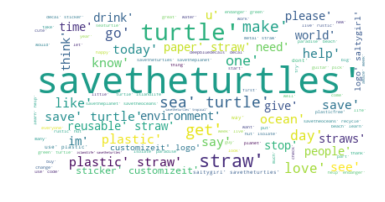

In [26]:
#let's try a wordcloud to visualize the most frequent words that appear
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

text3 = str(wn_pos(filtered_pos))

stop = set(STOPWORDS)
stop.update(['savetheturtles'])

wordcloud = WordCloud(stopwords=stop, max_font_size=75, max_words=100, background_color="white").generate(text3)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Looking at the timeline of tweets, we want to see if the viral impact of the turtle is still occurring 6 months later.

In [27]:
#convert timestamp to time series type
from pandas import Series, DataFrame
from datetime import datetime

#converting timestamp to a datetime object
df2 = df
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

In [28]:
df2 = df2.sort_values(by=['timestamp'])
df2.head()

,fullname,html,id,likes,replies,retweets,text,timestamp,url,user
44,CockO'Barton,"<p class=""TweetTextSize js-tweet-text tweet-te...",947792055174131714,6,0,5,Happy new year!!! What’s your resolution? Ours...,2018-01-01 11:30:09,/CockOBarton/status/947792055174131714,CockOBarton
43,Erin Tudryn,"<p class=""TweetTextSize js-tweet-text tweet-te...",948051541541445632,4,0,1,"And a picture is worth a 1,000 words so if you...",2018-01-02 04:41:16,/ErinTudryn03/status/948051541541445632,ErinTudryn03
42,Firebird PR,"<p class=""TweetTextSize js-tweet-text tweet-te...",948238057660182531,5,0,0,Some of the staff at @ScarsdaleVets have been ...,2018-01-02 17:02:25,/firebird_pr/status/948238057660182531,firebird_pr
41,Hannah,"<p class=""TweetTextSize js-tweet-text tweet-te...",948261701014601728,1,0,0,This year I am going plastic straw free. \n\n#...,2018-01-02 18:36:22,/me2hannah/status/948261701014601728,me2hannah
40,Elizabeth Russell,"<p class=""TweetTextSize js-tweet-text tweet-te...",948278583298052097,8,0,1,doing her part to help #savetheturtles @Reding...,2018-01-02 19:43:27,/RussellClass/status/948278583298052097,RussellClass


In [29]:
#since reset index caused a lot of trouble last time i'll make a new df again lol
df3 = df2
#Set 'Date' as the index of new df
df3.set_index('timestamp', inplace=True)

In [30]:
#round datetime to the day
df3.index = df3.index.floor('1D')
df3.head()

,fullname,html,id,likes,replies,retweets,text,url,user
timestamp,,,,,,,,,
2018-01-01,CockO'Barton,"<p class=""TweetTextSize js-tweet-text tweet-te...",947792055174131714,6,0,5,Happy new year!!! What’s your resolution? Ours...,/CockOBarton/status/947792055174131714,CockOBarton
2018-01-02,Erin Tudryn,"<p class=""TweetTextSize js-tweet-text tweet-te...",948051541541445632,4,0,1,"And a picture is worth a 1,000 words so if you...",/ErinTudryn03/status/948051541541445632,ErinTudryn03
2018-01-02,Firebird PR,"<p class=""TweetTextSize js-tweet-text tweet-te...",948238057660182531,5,0,0,Some of the staff at @ScarsdaleVets have been ...,/firebird_pr/status/948238057660182531,firebird_pr
2018-01-02,Hannah,"<p class=""TweetTextSize js-tweet-text tweet-te...",948261701014601728,1,0,0,This year I am going plastic straw free. \n\n#...,/me2hannah/status/948261701014601728,me2hannah
2018-01-02,Elizabeth Russell,"<p class=""TweetTextSize js-tweet-text tweet-te...",948278583298052097,8,0,1,doing her part to help #savetheturtles @Reding...,/RussellClass/status/948278583298052097,RussellClass


In [31]:
#reset index for value counts lol??
df3.reset_index('timestamp', inplace=True)

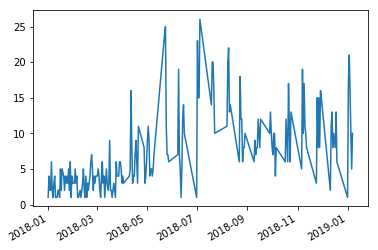

In [32]:
df3['timestamp'].value_counts().plot()
#make plot prettier tho

The number of tweets spike significantly in June, July, and August, reflecting the impact of the viral video. However, we can also see a definite trend afterwards as the number of tweets overall increase in later months to today. 

## Sentiment Analysis

Based off of various articles, I decided to try the NLTK module VADER to analyze individual tweets on the positive, negative, and neutral sentiment of each tweet. 

Resources: 
* http://www.nltk.org/howto/sentiment.html
* https://medium.com/@sharonwoo/sentiment-analysis-with-nltk-422e0f794b8
* http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html

In [33]:
#test of sentiment analyzer
test = df['text'][:10]
test

0    I'm so excited to volunteer at the turtle cons...
1    Buy na guys! #SavetheTurtles https://twitter.c...
2    Respect to the folks risking life and limb put...
3    Or dont use straw when in fastfood. #SaveTheTu...
4    STRAW SET for PHP 150 only \n\n- Metal straw\n...
5    GUYS LOOK!! #SaveTheTurtles  pic.twitter.com/e...
6    Please take a moment to check out this awesome...
7    #SaveTheTurtles .!!!! #SeaTurtles #NoLitterZon...
8    Inside the effort to save sea turtles stunned ...
9    Left my metal straw in my bag but I'm glad Tra...
Name: text, dtype: object

In [34]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shihe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [35]:
sid = SentimentIntensityAnalyzer()

#showing the sentiment scores for each tweet
for tweet in df['text']:
    print(tweet)
    ss = sid.polarity_scores(tweet)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print("\n")

I'm so excited to volunteer at the turtle conservation project  #savetheturtles #bali
compound: 0.4005, neg: 0.0, neu: 0.803, pos: 0.197, 

Buy na guys! #SavetheTurtles https://twitter.com/lebasyyy/status/953972101676916737 …
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Respect to the folks risking life and limb putting in long days and nights for a thankless job. For real thankless because turtles can not speak. #savetheturtles #thirdcoastproblems
compound: 0.2023, neg: 0.076, neu: 0.822, pos: 0.102, 

Or dont use straw when in fastfood. #SaveTheTurtles https://twitter.com/lebasyyy/status/953972101676916737 …
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

STRAW SET for PHP 150 only 

- Metal straw
- Milktea metal straw
- Bamboo straw
- Cleaning brush
- Pouch

#LessPlastic #SaveTheTurtles #Davaopic.twitter.com/OlkSTl2pze
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

GUYS LOOK!! #SaveTheTurtles  pic.twitter.com/e6sN1joEFl
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Please take a m


While we’re on the subject of #Savetheturtles https://greennews.ie/climate-change-decimating-male-green-sea-turtle-population-warn-researchers/ … #climatechange #ClimateActionpic.twitter.com/3xhk77UqXh
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

My new obsession is wood carving  love how this sea turtle came out!

#carver #woodcarve #woodcarving #woodart #woodartist #reliefcarving #pyro #flameon #pyrography #woodburn #woodburning #woodburn #beachart #comingsoon #seaglass #seaturtle #glassart #savetheturtles pic.twitter.com/eZOlN4hP7i
compound: 0.4753, neg: 0.065, neu: 0.813, pos: 0.122, 

Reusable stainless steel straws, instead of plastic, is the way to go. #savetheturtles #drinkBarPink #PassOnPlasticpic.twitter.com/pxOQNZ92qh – at Bar Pink
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Oh no... #savetheturtles
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

plastic. #nostraws #strawfree #savetheturtles #plasticfree #nosingleuseplastic #stopsucking #singleuseplastic #beachplastic #

compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Loggerhead Marinelife Center on #Yelp: Love this place!  #savetheturtles https://www.yelp.com/biz_photos/loggerhead-marinelife-center-juno-beach-2?pt=biz_photo&ref=twitter&select=U3p5_OmLmn1rjMCIi7IAFA …
compound: 0.6696, neg: 0.0, neu: 0.667, pos: 0.333, 

One of my last current #beachglass necklaces .
.
.
.
.
#upcycle #beach #beachglass #glass #seaglass #sand #beaches #savethelandfills #savetheocean #boho #bohostyle #sustainableliving #sustainablefashion #ecofriendly #savetheturtles #savethedolphins #slow… https://ift.tt/2MHtikk pic.twitter.com/JR0xl5U1T5
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Guests feedback on guest suite chalkboard door!
.
.
.
.
#guestroom #chalkboard #notes #thankyounotes #airbnbexperience #love #turtle #ssi #saintsimonsisland #iloveturtles #savetheturtles… https://www.instagram.com/p/BmWXNC8hrge/?utm_source=ig_twitter_share&igshid=ui7bkezmd7j6 …
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Hey Little Turtl

compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Mums don't need plastic this Mothers Day. Instead, adopt a sea turtle nest for them to ensure the survival of our shelled friends. #notoplastic #savetheturtles #osaturtles #osaecology https://www.facebook.com/281922731921840/posts/1833440770103354/ …
compound: 0.7506, neg: 0.0, neu: 0.764, pos: 0.236, 

 honestly though, please use alternatives to plastic straws or just don’t use them if you don’t need them. #savetheturtles pic.twitter.com/loUezyHXA4
compound: 0.6486, neg: 0.0, neu: 0.773, pos: 0.227, 

anybody renting out a mansion for 100$/month?? DM serious inquiries only #FEFE #TheShiggyChallenge #InternationalCatsDay #bigdickenergy #plzimadie #savetheturtles #paperstrawswitplasticwrappersmakenofuckinsensewtfbitch
compound: -0.168, neg: 0.094, neu: 0.906, pos: 0.0, 

We know plastic straws “suck” that’s why we use  compostable straws. We’ve been reducing our carbon footprint for 6 years now with plant-based, eco-friendly drinking straw

This little lady needed to get across Main St. #turtlecrossing #savetheturtles https://ift.tt/2sL8gcz pic.twitter.com/NSm0XEvAS2
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

#savetheturtles i feel bad for their mom  @heqasaad_https://twitter.com/fazlynn/status/1004906570856030208 …
compound: -0.5423, neg: 0.368, neu: 0.632, pos: 0.0, 

Please keep an eye out when driving-especially for the snappers on Ril Lake (and surrounding areas) that lay their eggs in the gravel and sand on the shoulder of our roads. #loveturtles #savetheturtles #HelpTheTurtleshttps://twitter.com/cwf_fcf/status/1005485464239865856 …
compound: 0.2023, neg: 0.042, neu: 0.894, pos: 0.064, 

I usually bust out anywhere from 200-400 drinks a night and put a straw in every single mixed drink. Last night in an attempt to be environmentally concious, i didn't put a straw in unless somebody requested it. In total, i used less than 15 straws! #savetheturtles !
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Great start @re

compound: 0.4941, neg: 0.0, neu: 0.775, pos: 0.225, 

YES!

How many #NinjaTurtle lives can we save?

#SaveTheTurtles https://twitter.com/KingofKSP/status/993131791220465664 …
compound: 0.7861, neg: 0.0, neu: 0.536, pos: 0.464, 

All 8 of Canada’s freshwater turtle species are at risk in most parts of Canada. Break for them. #SaveTheTurtles https://kitchener.ctvnews.ca/familiar-turtle-species-at-risk-in-waterloo-region-and-across-the-province-1.3913161 …
compound: -0.2732, neg: 0.104, neu: 0.896, pos: 0.0, 

Motion to serve sour punch straws at mid #savetheturtles
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

YESSS a step in the right direction #SayNoToStraws #SaveTheTurtles  https://twitter.com/mklozik/status/991324826718654465 …
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

“Yesterday morning our 2tank boat crew, guest & Dive Master Ramiz A Bhuiyan rescued a #oliveredleyturtle from a ghost net. The #turtle was luckily not injured or harm and was released to the water.”  
#savethetu

compound: 0.368, neg: 0.175, neu: 0.573, pos: 0.252, 

• BRAKE • FOR • TURTLES • 

Please stop  & allow them to cross, or help them across (in the same direction, or they will try it again )

Use a car mat (or your toes) to gently push him from the rear 
#turtles #savetheturtles #goodsamaritanpic.twitter.com/SSY4F6qKKR
compound: 0.7717, neg: 0.048, neu: 0.738, pos: 0.215, 

https://open.spotify.com/artist/6CdfglSniVbIx5eWgiSRif?si=iyopk4IuSY-kuHZ0BvdVew …
Get your Shred on Spotify Today
#savetheturtles #VonYorkUSA #sambonepromoshttps://open.spotify.com/artist/6CdfglSniVbIx5eWgiSRif?si=iyopk4IuSY-kuHZ0BvdVew …
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Fun Fact 1: Did you know only 1 in every 1000 sea turtles make it to adulthood? #savetheturtles #turtleslivesmatter #seathedifference
compound: 0.5106, neg: 0.0, neu: 0.845, pos: 0.155, 

“Travel at your own pace” #underwater #majestic #seaturtle #sea #deepsea #blue #savetheturtles #faunayflora #fauna #coralreef #beachwaves #bubbles #

#savetheturtles #ecofriendly #jaxbeachpic.twitter.com/USNCg0t0E5
compound: 0.8256, neg: 0.0, neu: 0.676, pos: 0.324, 

20 meters out #Pawikanlove #turtlesareawesome 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
. #savetheturtles #beachlife #heytheycontrolthejellyfishpopulationtoo @ Club Paradise Palawan https://www.instagram.com/p/BpSV3ygAKtz/?utm_source=ig_twitter_share&igshid=1edpwf6o7491c …
compound: 0.6369, neg: 0.0, neu: 0.724, pos: 0.276, 

We just recently went plastic straw free to #savetheturtles right @megmasc ;)
compound: 0.6369, neg: 0.0, neu: 0.658, pos: 0.342, 

The fact that Dolores Avery uses a reusable straw is all I need to know.  #MakingAMurderer
#SaveTheTurtles
#FreeStevenAndBrendan
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

ATTENTION IDIOTS: stop killing our planet
SAVE THE TURTLES #savetheturtles @connorfranta
https://youtu.be/HdngkSe6Ji4  via @YouTube
compound: -0.3954, neg: 0.307, neu: 0.511, pos: 0.183, 

Watch out for plastic straws #savetheturtles
compound: 0.0, neg: 0.0,

compound: 0.5411, neg: 0.0, neu: 0.863, pos: 0.137, 

Turtles need their nostrils; you don't need a #plasticstraw. #livekindly #plasticfree #savetheocean #savetheturtles #savethesea #conservation #zerowaste #strawfreeworldpic.twitter.com/hKACsSFHSa
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Mellow Mushroom gets it right!!
.
.
.
.
#strawlesssummer #4ocean #savetheturtles #ilovenature #itsallyoga #ahimsa #plastickills @ Mellow Mushroom https://www.instagram.com/p/Bm_d3l_jl3q/?utm_source=ig_twitter_share&igshid=pabmr4rpg98h …
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Even the animals are having to clean up the plastic waste!! This is disgusting & Heartbreaking! 
.
.
.
Follow @bambooherb
.
.
.
#gogreen #savetheturtles #plasticfreeliving #motherearth #waronwaste #wastefreepic.twitter.com/he3uQY8U82
compound: -0.8114, neg: 0.317, neu: 0.598, pos: 0.085, 

Happy #nationaldogday to my mess-making snuggles pups!! 

#deepbluedecals #decals #stickers #customizeit #logo #saltygirl #saveth

The Lara Bay Turtle Protection of Project #savetheturtles https://www.facebook.com/gingerbirdevans/videos/10156696721472125/ …
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

This little guy isn’t getting squished today #savetheturtles pic.twitter.com/PQltyedjdD
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Awesome!! Happy to see other restaurants skipping thr straw! #skipthestraw #savetheturtles #gogreen https://www.facebook.com/IzzyMidTown/posts/824802604390623 …
compound: 0.865, neg: 0.0, neu: 0.559, pos: 0.441, 

We are happy to be a part of assessing health and disease with @LCFPD for this endangered species with a smile! #blandingsturtle #research #savingtheworld #savetheturtles #EndangeredSpecieshttps://twitter.com/abc7chicago/status/999477660916092928 …
compound: 0.7574, neg: 0.0, neu: 0.772, pos: 0.228, 

#SaveTheTurtles Fundraiser on Facebook lemme know if you want the link!
compound: 0.1511, neg: 0.0, neu: 0.863, pos: 0.137, 

Many turtles were put to greet @KingsvilleCobra 

compound: 0.8655, neg: 0.075, neu: 0.582, pos: 0.343, 

i just bought 20 reusable straws and this is the best purchase i made this year :))))
#SAVETHETURTLES
compound: 0.6369, neg: 0.0, neu: 0.781, pos: 0.219, 

1/3rd of all turtles are crab food. True fact. #savetheturtles
compound: 0.4215, neg: 0.0, neu: 0.763, pos: 0.237, 

People like this are the people who kill the earth with pollution. #savetheturtles #savethedolphins #recycle
compound: -0.4939, neg: 0.233, neu: 0.644, pos: 0.124, 

#tipoftheday use less straws. I know I can't save the world by myself but one step at a time. #savetheturtles #savetheenviornment #cleanwater #ourearth #save #nolittering #conservation
compound: -0.2057, neg: 0.076, neu: 0.924, pos: 0.0, 

We are entering the last month of #turtlenestingseasion. Remember to keep your blinds closed at night so the hatchlings don’t get confused! They use light to guide them to the water. #savetheturtles pic.twitter.com/X2MWxxIZi7
compound: -0.3802, neg: 0.075, neu: 0.9

It’s #savetheturtles season you guys lol
compound: 0.4215, neg: 0.0, neu: 0.641, pos: 0.359, 

Good morning and happy Monday Turtle Lovers! #savetheturtles  pic.twitter.com/Te4qzAZwKL
compound: 0.8832, neg: 0.0, neu: 0.368, pos: 0.632, 

If plastic use continues at the current rate By 2050, there may be more plastic in the sea than fish. https://buff.ly/2qw0e6j  #Savetheturtles pic.twitter.com/oUyeoHHTzP
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Last year at this time I was saving turtles ..... #winterinapril #savetheturtles
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

Shelly Cove mystery bag has been restocked in all sizes!! Who’s excited?!?  I know I am  Use code #Catherine10 for 10% off your order!  #shellycove #mysterybag #excited #iwantone #savetheturtles #turtlelove #turtles #socute #yespleasepic.twitter.com/Q25L8ZB7Gt
compound: 0.6031, neg: 0.0, neu: 0.884, pos: 0.116, 

Shop Shelly cove! Every purchase helps save sick and injured turtles! Use code JACKIEO10 for discount 

compound: -0.6486, neg: 0.301, neu: 0.699, pos: 0.0, 

@DougBenson Hi Doug, I was listening to the most recent ep of #DiningWithD&K and you guys mentioned reusable straws. This is a great one, I got it recently, it travels well. #savetheturtles https://finalstraw.com/products/finalstraw … @KarenAndersonHi @ArdenMyrin
compound: 0.7351, neg: 0.0, neu: 0.829, pos: 0.171, 

What a cute turtle... it would be a shame if someone just... ATE A FUCKIN FRAPUCCINO WITH A STRAW.

but 4real, #savetheturtles #nostrawganghttps://twitter.com/picsbeaches/status/1073299083475984386 …
compound: -0.0129, neg: 0.097, neu: 0.808, pos: 0.095, 

let’s take Final Straw for example. I believe I paid $20 a straw carrying case included....they make that damn thing for $5. #SaveTheTurtles...starting to think #SaveforNyRetirement
compound: -0.4019, neg: 0.109, neu: 0.891, pos: 0.0, 

There is still time to catch the @ShopShellyCove sale! Your purchase really helps make a difference for the sea turtles Don't forget 

It's really cool to see this output. The VADER sentiment analyzer outputs four scores:

* neg: Negative
* neu: Neutral
* pos: Positive
* compound: Compound (i.e. aggregated score)

The neg, neu, and pos scores show the

In [36]:
summary = {"positive":0,"neutral":0,"negative":0}
for tweet in df['text']: 
    ss = sid.polarity_scores(tweet)
    if ss["compound"] == 0.0: 
        summary["neutral"] +=1
    elif ss["compound"] > 0.0:
        summary["positive"] +=1
    else:
        summary["negative"] +=1
print(summary)

{'positive': 788, 'neutral': 413, 'negative': 287}


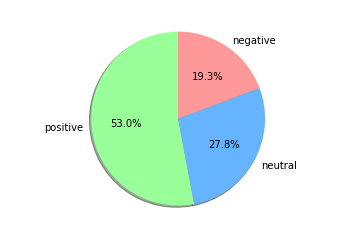

In [37]:
import matplotlib.pyplot as pyplot
keys = summary.keys()
values = summary.values()

#add colors
colors = ['#99ff99', '#66b3ff','#ff9999']

pyplot.axis("equal") # Equal aspect ratio ensures that pie is drawn as a circle
pyplot.pie(values,labels=keys,colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
pyplot.show()

By looking at the total distribution of the compound scores of all tweets, we can see that overall, over 50% of the tweets are positive, with 25% neutral and 20% negative. 

Although the VADER package is a powerful package, it was not perfect. There are still classification mistakes when you look closely. I believe this is because of the training dictionaries used in many sentiment analyzers to track positivity/negativity and the continued subleties of the English language. VADER has many useful approaches for reviews. For example, it can successfully interpret intensity of a positive sentiment, such as when "excellent" is treated as more positive than just "good". However, tweets are not explicitly "reviews" and positive tweets may not use such words. For example:

![title](majorrr.jpg)

Misspelling of "MAJOR" and use of slang such as "props" means the excited approval in this tweet was lost on our analyzer.
Or in this case...

![title](sarcasm.jpg)

Sarcasm unfortunately not detected! 

Perhaps in the future, I could implement the retweets and likes columns into the analysis as a measure of positive support. I would greatly appreciate any input or advice into how to do so!

In [38]:
#for future analysis?
#created new column of df2 with sentiment value
def sentiment_column(tweet):
    ss = sid.polarity_scores(tweet)
    if ss["compound"] == 0.0: 
        return 'neutral'
    elif ss["compound"] > 0.0:
        return 'positive'
    else:
        return 'negative'

df2['sentiment'] = df2['text'].map(sentiment_column)
df2['sentiment'].value_counts()

positive    788
neutral     413
negative    287
Name: sentiment, dtype: int64

## This is extra stuff, not really sure where I'm going here or what it's doing lol. Experimenting with time slices...

In [39]:
#make slices, sentiment by slice?
dates = pd.date_range(start='5/2/2018', end='6/2/2018', freq='D') #change around dates
df_spike1 = df3.loc[dates]
print(len(df_spike1))
df_spike1['sentiment'].value_counts()

KeyError: "None of [DatetimeIndex(['2018-05-02', '2018-05-03', '2018-05-04', '2018-05-05',\n               '2018-05-06', '2018-05-07', '2018-05-08', '2018-05-09',\n               '2018-05-10', '2018-05-11', '2018-05-12', '2018-05-13',\n               '2018-05-14', '2018-05-15', '2018-05-16', '2018-05-17',\n               '2018-05-18', '2018-05-19', '2018-05-20', '2018-05-21',\n               '2018-05-22', '2018-05-23', '2018-05-24', '2018-05-25',\n               '2018-05-26', '2018-05-27', '2018-05-28', '2018-05-29',\n               '2018-05-30', '2018-05-31', '2018-06-01', '2018-06-02'],\n              dtype='datetime64[ns]', freq='D')] are in the [index]"

In [ ]:
df_spike1

In [ ]:
dates = pd.date_range(start='6/2/2018', end='7/2/2018', freq='D') #change around dates
df_spike1 = df3.loc[dates]
print(len(df_spike1))
df_spike1['sentiment'].value_counts()

In [ ]:
dates = pd.date_range(start='7/2/2018', end='8/2/2018', freq='D') #change around dates
df_spike1 = df3.loc[dates]
print(len(df_spike1))
df_spike1['sentiment'].value_counts()

In [ ]:
dates = pd.date_range(start='8/2/2018', end='9/2/2018', freq='D') #change around dates
df_spike1 = df3.loc[dates]
print(len(df_spike1))
df_spike1['sentiment'].value_counts()

In [ ]:
dates = pd.date_range(start='9/2/2018', end='10/2/2018', freq='D') #change around dates
df_spike1 = df3.loc[dates]
print(len(df_spike1))
df_spike1['sentiment'].value_counts()

In [ ]:
dates = pd.date_range(start='10/2/2018', end='11/2/2018', freq='D') #change around dates
df_spike1 = df3.loc[dates]
print(len(df_spike1))
df_spike1['sentiment'].value_counts()

In [ ]:
dates = pd.date_range(start='11/2/2018', end='12/2/2018', freq='D') #change around dates
df_spike1 = df3.loc[dates]
print(len(df_spike1))
df_spike1['sentiment'].value_counts()

In [ ]:
df3.head()